# Word vectors

In this notebook we will explore word vectors. We will use the vectors from [spaCy](http://spacy.io).

In [1]:
import spacy

## Inspecting what is there

Load the large English language model. This can take a few seconds.

In [2]:
nlp = spacy.load('en_core_web_lg')

Every word in the vocabulary comes with a 300-dimensional vector, represented as a NumPy array. Here is the vector for *cheese*:

In [3]:
nlp.vocab['cheese'].vector

array([-5.5252e-01,  1.8894e-01,  6.8737e-01, -1.9789e-01,  7.0575e-02,
        1.0075e+00,  5.1789e-02, -1.5603e-01,  3.1941e-01,  1.1702e+00,
       -4.7248e-01,  4.2867e-01, -4.2025e-01,  2.4803e-01,  6.8194e-01,
       -6.7488e-01,  9.2401e-02,  1.3089e+00, -3.6278e-02,  2.0098e-01,
        7.6005e-01, -6.6718e-02, -7.7794e-02,  2.3844e-01, -2.4351e-01,
       -5.4164e-01, -3.3540e-01,  2.9805e-01,  3.5269e-01, -8.0594e-01,
       -4.3611e-01,  6.1535e-01,  3.4212e-01, -3.3603e-01,  3.3282e-01,
        3.8065e-01,  5.7427e-02,  9.9918e-02,  1.2525e-01,  1.1039e+00,
        3.6678e-02,  3.0490e-01, -1.4942e-01,  3.2912e-01,  2.3300e-01,
        4.3395e-01,  1.5666e-01,  2.2778e-01, -2.5830e-02,  2.4334e-01,
       -5.8136e-02, -1.3486e-01,  2.4521e-01, -3.3459e-01,  4.2839e-01,
       -4.8181e-01,  1.3403e-01,  2.6049e-01,  8.9933e-02, -9.3770e-02,
        3.7672e-01, -2.9558e-02,  4.3841e-01,  6.1212e-01, -2.5720e-01,
       -7.8506e-01,  2.3880e-01,  1.3399e-01, -7.9315e-02,  7.05

## Cleaning the vocabulary

Because the language model was built from web data, its vocabulary is rather large (ca. 1.3 million entries) and contains a lot of non-conventional words:

In [4]:
for i, word in enumerate(nlp.vocab):
    if i >= 10:
        break
    print(word.orth_)

EDPT
croup
Blunt.
CAFFIAUX
beruhigt
Sibs
Ginjo
stumpfe
gorey
here..i


We remove words with no word vectors (null vectors) and non-alphabetic characters, and normalise to lowercase. However, for each normalised word we keep the word vectors of all non-normalised word forms.

In [5]:
w2v = {}
for word in nlp.vocab:
    if word.has_vector:
        w = word.orth_.lower()
        if w.isalpha():
            if w not in w2v:
                w2v[w] = []
            w2v[w].append(word.vector)

The table `w2v` now holds the word vectors for all different forms of *cheese*.

In [6]:
len(w2v['cheese'])

3

We now construct a new vocabulary where the vector for each word is the average of the vectors of the different word forms in the old vocabulary. For this we need to load NumPy.

In [7]:
from spacy.vocab import Vocab

import numpy as np

lc_vocab = Vocab(strings=w2v.keys())
for w in lc_vocab:
    lc_vocab.set_vector(w.orth, np.mean(np.array(w2v[w.orth_]), axis=0))

Here is the size of the new vocabulary:

In [8]:
len(lc_vocab)

247551

Here is the new vector for *cheese*:

In [9]:
lc_vocab['cheese'].vector

array([-5.5251998e-01,  1.8894000e-01,  6.8737000e-01, -1.9789000e-01,
        7.0574999e-02,  1.0075001e+00,  5.1789001e-02, -1.5603000e-01,
        3.1941000e-01,  1.1702000e+00, -4.7247997e-01,  4.2867002e-01,
       -4.2025003e-01,  2.4803001e-01,  6.8194002e-01, -6.7488003e-01,
        9.2400998e-02,  1.3089000e+00, -3.6277998e-02,  2.0097999e-01,
        7.6005000e-01, -6.6717997e-02, -7.7794001e-02,  2.3843999e-01,
       -2.4350999e-01, -5.4163998e-01, -3.3539999e-01,  2.9804999e-01,
        3.5269001e-01, -8.0593997e-01, -4.3610999e-01,  6.1535001e-01,
        3.4212002e-01, -3.3603001e-01,  3.3282000e-01,  3.8065001e-01,
        5.7427000e-02,  9.9918000e-02,  1.2525000e-01,  1.1039000e+00,
        3.6678001e-02,  3.0489999e-01, -1.4941999e-01,  3.2912001e-01,
        2.3300000e-01,  4.3395004e-01,  1.5666001e-01,  2.2778000e-01,
       -2.5830001e-02,  2.4334000e-01, -5.8136001e-02, -1.3485999e-01,
        2.4521001e-01, -3.3458999e-01,  4.2839000e-01, -4.8181000e-01,
      

## Computing cosine similarities

Now we define a function that computes the pairwise cosine similarities between a word and all other words in the vocabulary.

In [10]:
from sklearn.metrics import pairwise_distances

def most_similar(word, k=10):
    m = word.vocab.vectors.data
    x = np.array([word.vector])
    c = np.reshape(1 - pairwise_distances(m, x, metric='cosine'), -1)
    return sorted(word.vocab, key=lambda w: c[word.vocab.vectors.key2row[w.orth]], reverse=True)[:k]

What are the most similar words to *cheese*?

In [11]:
for word in most_similar(lc_vocab['cheese']):
    print(word.orth_)

cheese
cheddar
bacon
cheeses
mozzarella
butter
sausage
salad
bread
sauce


## Visualising word similarities

To visualise word vectors, we project them two a 2-dimensional plane using [t-SNE](https://lvdmaaten.github.io/tsne/), and plot the result.

In [12]:
%matplotlib inline

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

def display_most_similar(*words):
    xs = []
    ls = []
    for word in words:
        for w in most_similar(word):
            xs.append(w.vector)
            ls.append(w.orth_)
    tsne = TSNE(n_components=2, random_state=0)
    y = tsne.fit_transform(xs)
    x_coords = y[:, 0]
    y_coords = y[:, 1]
    plt.figure(figsize=(12, 8))
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(ls, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(5, 5), textcoords='offset points', size=15)
    plt.xlim(x_coords.min()-50, x_coords.max()+50)
    plt.ylim(y_coords.min()-50, y_coords.max()+50)
    plt.show()

Here are the neighbours of *cheese*.

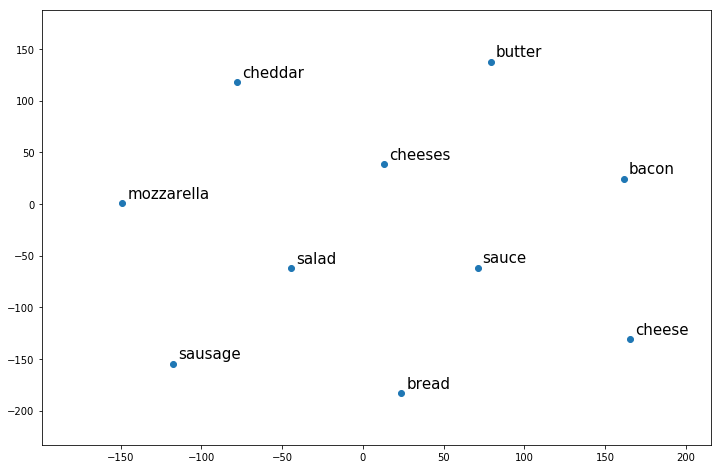

In [13]:
display_most_similar(lc_vocab['cheese'])

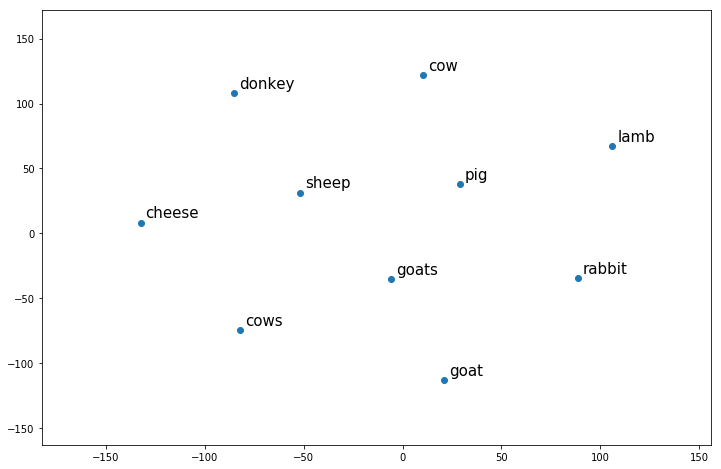

In [14]:
display_most_similar(lc_vocab['goat'])

When adding more words, we see a cluster structure:

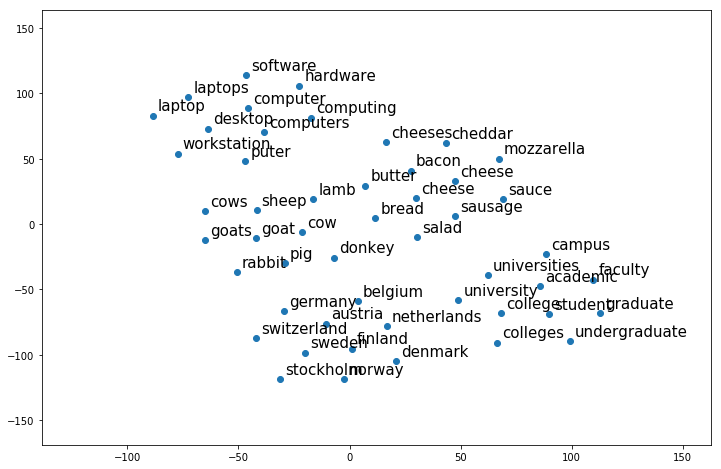

In [15]:
display_most_similar(lc_vocab['cheese'], lc_vocab['goat'], lc_vocab['sweden'], lc_vocab['university'], lc_vocab['computer'])

## Analogies

We start by defining a function that will find the closest word for a given vector (not necessarily a word vector).

In [16]:
from sklearn.metrics import pairwise_distances

def closest_word(vocab, x, exclude=[]):
    m = vocab.vectors.data
    x = np.array([x])
    c = np.reshape(1 - pairwise_distances(m, x, metric='cosine'), -1)
    for word in sorted(vocab, key=lambda w: c[vocab.vectors.key2row[w.orth]], reverse=True):
        if word not in exclude:
            return word

Of course, the closest word to *cheese* is *cheese*:

In [17]:
closest_word(lc_vocab, lc_vocab['cheese'].vector).orth_

'cheese'

What is the closest word to *cheese* if we exclude *cheese* itself?

In [18]:
closest_word(lc_vocab, lc_vocab['cheese'].vector, exclude=[lc_vocab['cheese']]).orth_

'cheddar'

We can now write a function that &lsquo;calculates&rsquo; with words.

In [19]:
def analogy(word1, word2, word3):
    x = word1.vector - word2.vector + word3.vector
    return closest_word(word1.vocab, x, exclude=[word1, word2, word3])

Here is the famous king &minus; man + woman = ? example.

In [20]:
analogy(lc_vocab['king'], lc_vocab['man'], lc_vocab['woman']).orth_

'queen'

The model knows the capital of Sweden.

In [21]:
analogy(lc_vocab['berlin'], lc_vocab['germany'], lc_vocab['sweden']).orth_

'stockholm'

The embedding also &lsquo;learns&rsquo; some syntactic analogies, such as the analogy between the past-tense and present-tense forms of verbs (here: *jump* and *eat*):

In [22]:
analogy(lc_vocab['jumped'], lc_vocab['jump'], lc_vocab['eat']).orth_

'ate'

## Limitations

The model is not good at distinguishing between synonyms and antonyms:

In [23]:
[w.orth_ for w in most_similar(lc_vocab['alive'])]

['alive',
 'dying',
 'dead',
 'forever',
 'survive',
 'lives',
 'life',
 'still',
 'gone',
 'never']

When experimenting with analogy examples, you will find that the embedding picks up common stereotypes:

In [24]:
analogy(lc_vocab['doctor'], lc_vocab['man'], lc_vocab['woman']).orth_

'nurse'

In [25]:
analogy(lc_vocab['germany'], lc_vocab['beer'], lc_vocab['wine']).orth_

'italy'

Is a *cat* more closely related to a *dog* or to a *tiger*?

In [26]:
[w.orth_ for w in most_similar(lc_vocab['cat'])]

['cat',
 'cats',
 'kitten',
 'dog',
 'kitty',
 'pet',
 'puppy',
 'kittens',
 'feline',
 'dogs']

In [27]:
[w.orth_ for w in most_similar(lc_vocab['tiger'])]

['tiger',
 'tigers',
 'lion',
 'panther',
 'elephant',
 'leopard',
 'panda',
 'rhino',
 'cheetah',
 'lions']